In [1]:
import os
import pickle
import numpy as np
from scipy.ndimage.morphology import distance_transform_edt
import seaborn as sns
sns.set(style='ticks')
from scout import io
from scout.utils import read_voxel_size

In [27]:
working_dir = '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190419_14_35_07_AA_org1_488LP13_561LP120_642LP60/'
os.listdir(working_dir)

['organoid_features.xlsx', 'dataset', 'cyto_labels.npy', 'cyto_names.csv']

In [28]:
voxel_size = read_voxel_size(os.path.join(working_dir, 'dataset/voxel_size.csv'))
voxel_size

(2.0, 0.651, 0.651)

In [4]:
downsample_factor = (1, 6, 6)
downsampled_voxel_size = tuple([d * f for d, f in zip(voxel_size, downsample_factor)])
downsampled_voxel_size

(2.0, 3.906, 3.906)

In [5]:
foreground = io.imread(os.path.join(working_dir, 'dataset/segment_foreground.tif'))
foreground.shape, foreground.max()

((1500, 634, 634), 255)

In [6]:
mask = foreground > 0
mask.shape, mask.max()

((1500, 634, 634), True)

In [7]:
edt = distance_transform_edt(mask, sampling=downsampled_voxel_size)
edt.shape, edt.min(), edt.max()

((1500, 634, 634), 0.0, 565.1854345610827)

In [8]:
io.imsave(os.path.join(working_dir, 'dataset/segment_edt.tif'), edt)

In [9]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


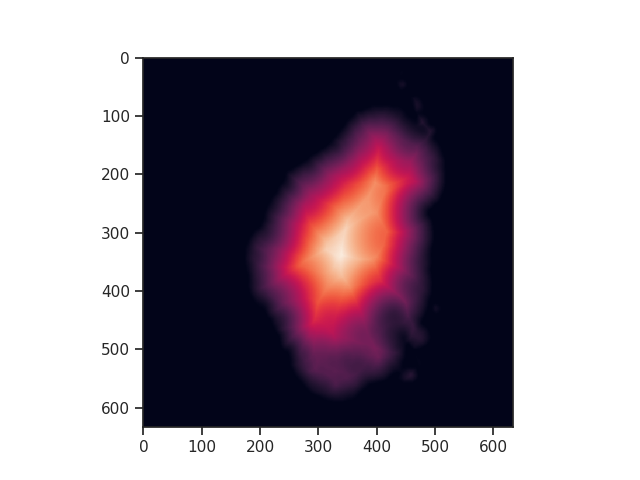

In [10]:
plt.imshow(edt[400])
plt.show()

In [11]:
boundary = np.logical_and(mask, (edt < 4))  # ~1 px boundary

<IPython.core.display.Javascript object>


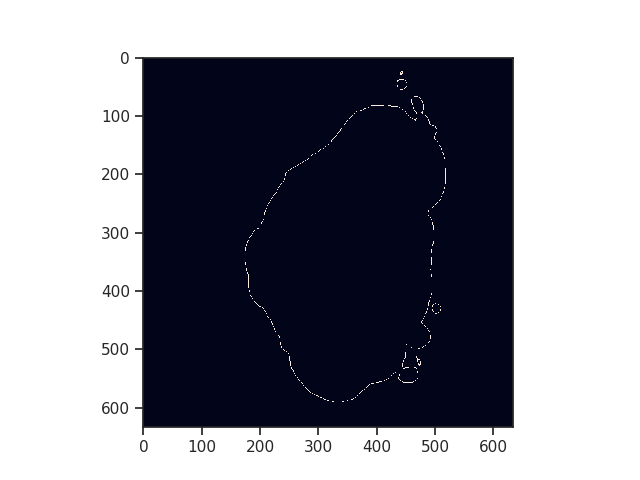

In [12]:
plt.imshow(boundary[400], clim=[0, 1])
plt.show()

In [13]:
surface_idx = np.where(boundary)
surface_pts = np.asarray(surface_idx).T * np.asarray(downsampled_voxel_size)
surface_pts.shape  # in micron

(1366136, 3)

Get the normal vectors and surface vectors

In [29]:
with open(os.path.join(working_dir, 'dataset/mesh_ventricles.pkl'), mode='rb') as f:
    mesh = pickle.load(f)
verts = mesh['verts']
faces = mesh['faces']
normals = mesh['normals']
values = mesh['values']

normals.shape

(86770, 3)

In [15]:
from sklearn.neighbors import NearestNeighbors

In [16]:
nbrs = NearestNeighbors(n_neighbors=1).fit(surface_pts)

In [17]:
dist, idx = nbrs.kneighbors(verts)

In [114]:
dist = dist[:, 0]
dist

array([128.01441555, 130.51661971, 128.63165125, ...,  72.7392366 ,
        70.1391353 ,  73.58131783])

In [18]:
nearest_surface_pts = surface_pts[idx[:, 0]]
surface_vectors = nearest_surface_pts - verts
surface_vectors = surface_vectors / np.linalg.norm(surface_vectors, axis=-1)[:, np.newaxis]

In [19]:
np.linalg.norm(surface_vectors, axis=-1), np.linalg.norm(normals, axis=-1)

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([1.        , 1.        , 1.        , ..., 1.        , 0.99999994,
        0.99999994], dtype=float32))

In [20]:
dot_products = (surface_vectors * normals).sum(axis=-1)
dot_products.shape, dot_products.min(), dot_products.max()

((86770,), -0.9998989684996982, 0.9999785202659601)

In [21]:
thetas = np.arccos(dot_products) / np.pi * 180

<IPython.core.display.Javascript object>


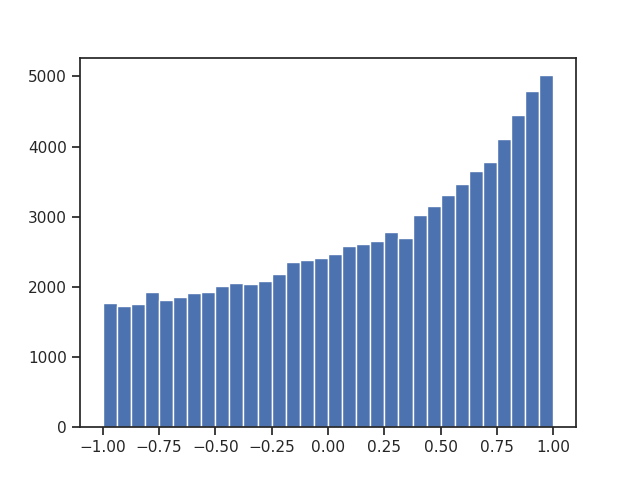

In [25]:
plt.hist(dot_products, bins=32)
plt.show()

In [30]:
labels = np.load(os.path.join(working_dir, 'cyto_labels.npy'))

labels.shape, np.unique(labels)

((86770,), array([0, 1, 2, 4, 5]))

In [33]:
from scout.utils import read_csv

In [34]:
cyto_names = read_csv(os.path.join(working_dir, 'cyto_names.csv'))

<IPython.core.display.Javascript object>


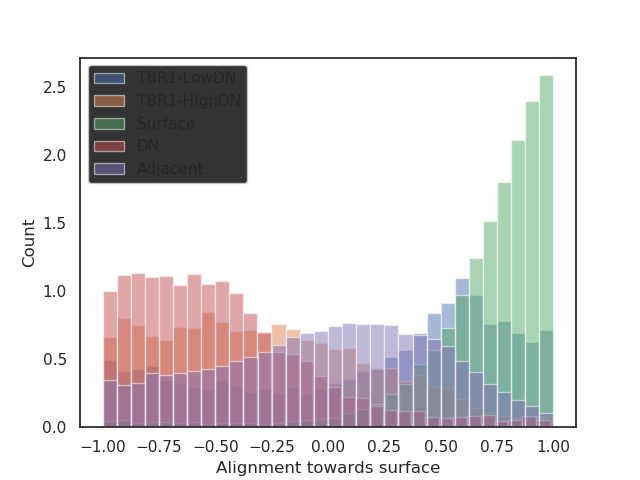

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


In [55]:
plt.figure()
for lbl in np.unique(labels):
    loc = np.where(labels == lbl)[0]
    dot_products_lbl = dot_products[loc]
    plt.hist(dot_products_lbl, bins=32, alpha=0.5, label=cyto_names[lbl], normed=True)

plt.xlabel('Alignment towards surface')
plt.ylabel('Count')
plt.legend()
plt.show()

In [36]:
import pandas as pd

In [37]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

In [38]:
df = pd.DataFrame({'x': dot_products, 'g': labels})
df.head()

,x,g
0,0.917914,2
1,0.887534,2
2,0.867835,2
3,0.972249,2
4,0.808750,2


<IPython.core.display.Javascript object>


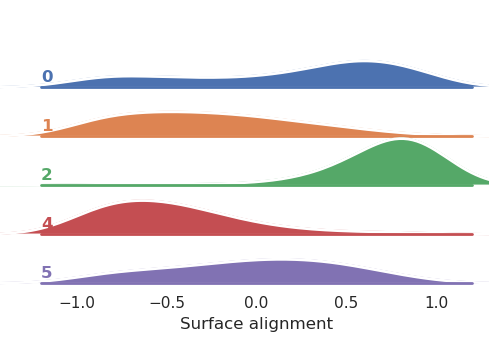

In [39]:
# Initialize the FacetGrid object
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=7, height=0.7)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
plt.xlim([-1.2, 1.2])
plt.xlabel('Surface alignment')
g.despine(bottom=True, left=True)

In [40]:
import joblib
from scout.cyto import profiles_to_features

In [41]:
model_path = os.path.abspath(os.path.join(working_dir, os.pardir, os.pardir, 'model_d35_d60.umap'))
model_path

'/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/model_d35_d60.umap'

In [42]:
model = joblib.load(model_path)
model

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

In [44]:
profiles = np.load(os.path.join(working_dir, 'dataset/cyto_profiles.npy'))

In [45]:
x_umap = model.transform(profiles_to_features(profiles, normalize=False))

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.conda/envs/scout/lib/python3.6/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  self.func_ir.loc))
/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.conda/envs/scout/lib/python3.6/site-packag

In [46]:
x_umap.shape

(86770, 2)

<IPython.core.display.Javascript object>


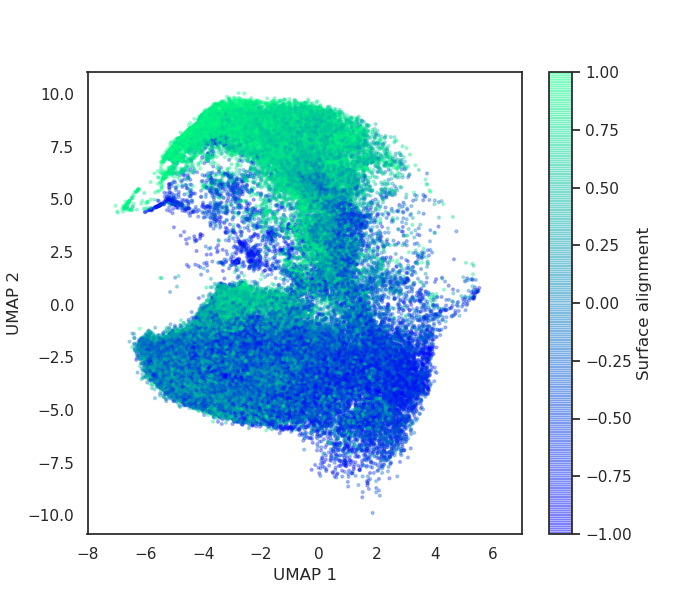

In [47]:
plt.figure(figsize=(7, 6))
plt.scatter(x_umap[:, 0], x_umap[:, 1], c=dot_products, s=4, cmap='winter', alpha=0.3, vmin=-1, vmax=1)
plt.xlim([-8, 7])
# plt.ylim([-8.5, 9])
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Surface alignment')
plt.show()

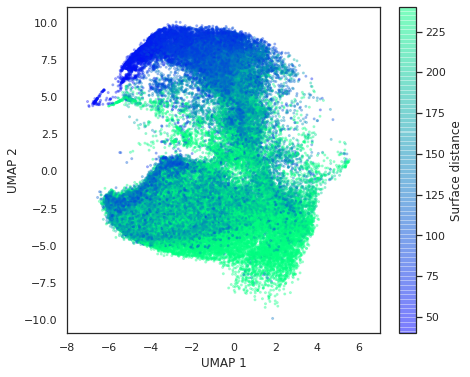

In [253]:
plt.figure(figsize=(7, 6))
plt.scatter(x_umap[:, 0], x_umap[:, 1], c=dist, s=4, cmap='winter', alpha=0.3, vmin=40, vmax=240)
plt.xlim([-8, 7])
# plt.ylim([-8.5, 9])
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Surface distance')
plt.show()

In [183]:
from mayavi import mlab

In [187]:
scalars = ((dot_products + 1) / 2 * 255).astype(np.int)

surf = mlab.triangular_mesh([vert[0] for vert in verts],
                     [vert[1] for vert in verts],
                     [vert[2] for vert in verts],
                     faces,
                     colormap='cool',
                    vmin=0,
                    vmax=255,
                     scalars=scalars)

mlab.show()

Show that orientation is correlated with various features of cytoarchitectural profiles
- Surface orientation vs tbr1 count

In [80]:
read_csv(os.path.join(working_dir, 'dataset/celltype_names.csv')), cyto_names

(['sox2', 'tbr1', 'dn'],
 ['TBR1-LowDN', 'TBR1-HighDN', 'Surface', 'Artifacts', 'DN', 'Adjacent'])

In [83]:
sox2_counts = profiles[:, 0, :].sum(axis=-1)
tbr1_counts = profiles[:, 1, :].sum(axis=-1)
dn_counts = profiles[:, 2, :].sum(axis=-1)
tbr1_counts.shape

(86770,)

In [107]:
adj_idx = np.where(labels==5)[0]
surface_idx = np.where(labels==2)[0]
dn_idx = np.where(labels==4)[0]

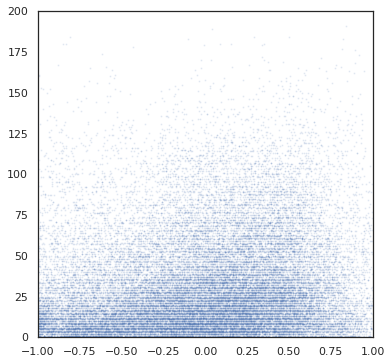

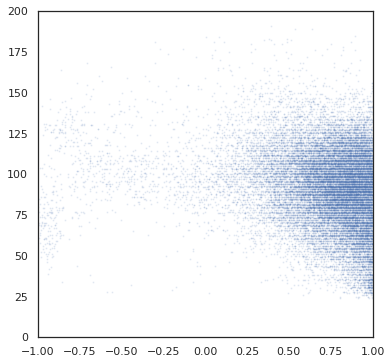

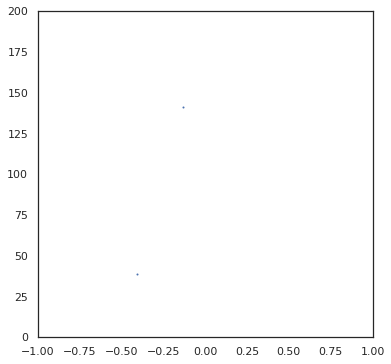

In [109]:
%matplotlib inline

plt.figure(figsize=(6,6))
plt.scatter(dot_products[adj_idx], sox2_counts[adj_idx], s=1, alpha=0.1)
plt.xlim([-1, 1])
plt.ylim([0, 200])
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(dot_products[surface_idx], tbr1_counts[surface_idx], s=1, alpha=0.1)
plt.xlim([-1, 1])
plt.ylim([0, 200])
plt.show()


plt.figure(figsize=(6,6))
plt.scatter(dot_products[dn_idx], dn_counts[dn_idx], s=1, alpha=0.1)
plt.xlim([-1, 1])
plt.ylim([0, 200])
plt.show()

In [202]:
dist2 = dist[surface_idx]
thetas2 = thetas[surface_idx]
tbr1_freq = tbr1_counts[surface_idx] / totals[surface_idx]
dn_freq = dn_counts[surface_idx] / totals[surface_idx]

loc = np.where(thetas2 < 90)[0]

dist2 = dist2[loc]
thetas2 = thetas2[loc]
tbr1_freq = tbr1_freq[loc]
dn_freq = dn_freq[loc]

loc = np.where(dist2 < 250)[0]

dist2 = dist2[loc]
thetas2 = thetas2[loc]
tbr1_freq = tbr1_freq[loc]
dn_freq = dn_freq[loc]

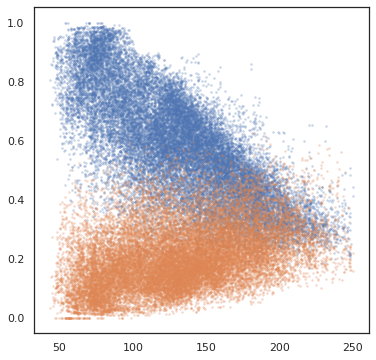

In [203]:
plt.figure(figsize=(6,6))
plt.scatter(dist2, tbr1_freq, s=3, alpha=0.2)
plt.scatter(dist2, dn_freq, s=3, alpha=0.2)
# plt.xlim([0, 90])
# plt.ylim([0, 1])
plt.show()

In [204]:
df = pd.DataFrame({'theta': thetas2, 
                        'tbr1_freq': tbr1_freq,
                        'dn_freq': dn_freq,
                  'dist': dist2})
df.head()

,theta,tbr1_freq,dn_freq,dist
0,23.377004,0.718310,0.154930,128.014416
1,27.435074,0.659864,0.176871,130.516620
2,29.791923,0.664336,0.174825,128.631651
3,13.529574,0.763780,0.133858,126.706478
4,36.026057,0.636364,0.188312,133.221248


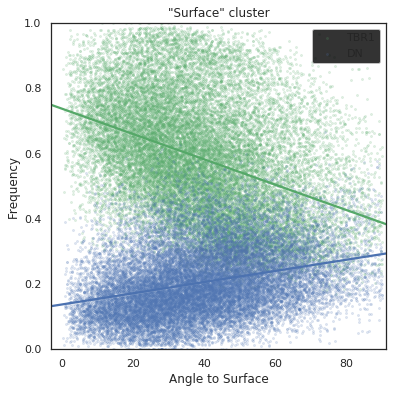

In [205]:
%matplotlib inline
plt.figure(figsize=(6, 6))
sns.regplot(x='theta', y='tbr1_freq', data=df, n_boot=1, scatter_kws={'s': 4, 'alpha': 0.15}, label='TBR1', color='g')
sns.regplot(x='theta', y='dn_freq', data=df, n_boot=1, scatter_kws={'s': 4, 'alpha': 0.15}, label='DN', color='b')
plt.xlim([-3, 91])
plt.ylim([0, 1])
plt.xlabel('Angle to Surface')
plt.ylabel('Frequency')
plt.title('"Surface" cluster')
plt.legend()
plt.show()

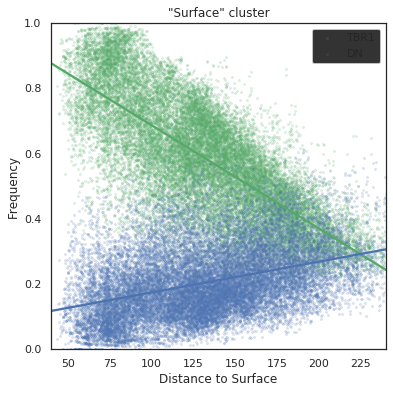

In [211]:
%matplotlib inline
plt.figure(figsize=(6, 6))
sns.regplot(x='dist', y='tbr1_freq', data=df, n_boot=10, scatter_kws={'s': 4, 'alpha': 0.15}, label='TBR1', color='g')
sns.regplot(x='dist', y='dn_freq', data=df, n_boot=10, scatter_kws={'s': 4, 'alpha': 0.15}, label='DN', color='b')
plt.xlim([40, 240])
plt.ylim([0, 1])
plt.xlabel('Distance to Surface')
plt.ylabel('Frequency')
plt.title('"Surface" cluster')
plt.legend()
plt.show()

In [317]:
df.head()

,theta,tbr1_freq,dn_freq,dist
0,23.377004,0.718310,0.154930,128.014416
1,27.435074,0.659864,0.176871,130.516620
2,29.791923,0.664336,0.174825,128.631651
3,13.529574,0.763780,0.133858,126.706478
4,36.026057,0.636364,0.188312,133.221248


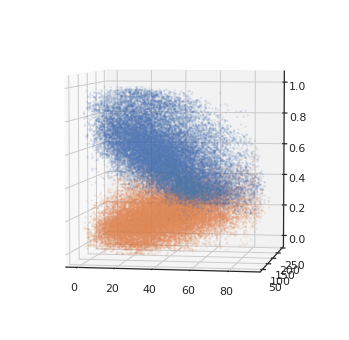

In [250]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(thetas2, dist2, tbr1_freq, s=2, alpha=0.1)
ax.scatter(thetas2, dist2, dn_freq, s=2, alpha=0.1)

ax.view_init(elev=5, azim=-80)
fig.show()

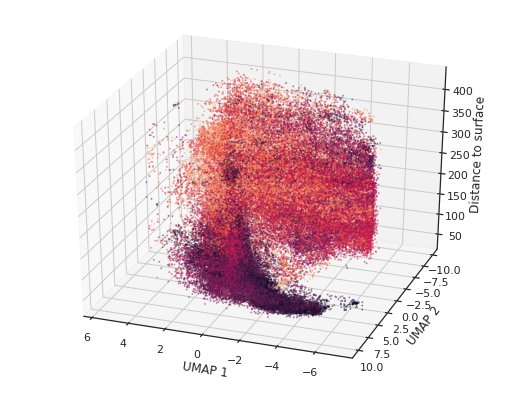

In [315]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_umap[:, 0], x_umap[:, 1], dist, s=1, alpha=0.4, c=thetas)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
ax.set_zlabel('Distance to surface')

ax.view_init(elev=30, azim=110)
fig.show()

SyntaxError: unexpected character after line continuation character (<ipython-input-254-e0caa251eefc>, line 1)